# **Wedding prediction**

**Author** :Thomas Benyazza

**Laboratory**: PSL

**Date** : 23 November 2024

#### Project Objective
**Goal**: Accurately predict the presence of the term "marriage" in text descriptions based on student annotations.

**Problem Type**: This is a classification problem where the target variable, txtMarr, is binary, indicating whether or not a marriage is mentioned.

# **I. Bag of words**

## 1. Library import

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
print("Libraries imported successfully.")

Libraries imported successfully.


## 1.2 Function import

In [103]:
def plot_sorted_coefficients(coef, threshold = 1e-08, top_n=30):
    sorted_coef = coef.abs().sort_values().tail(top_n)
    original_sorted_coef = coef.loc[sorted_coef.index]
    plt.figure(figsize=(8, 5))
    colors = [
        'grey' if abs(c) < threshold else 'green' if c > 0 else 'red'
        for c in original_sorted_coef
    ]

    plt.scatter(sorted_coef.values, sorted_coef.index, color = colors, zorder = 5)

    for i in range(len(sorted_coef)):
        plt.plot([0, sorted_coef.values[i]], [i, i], color = 'skyblue', lw = 2)

    plt.axvline(x = 0, color = 'gray', linestyle = '--', linewidth = 1)
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Logistic Regression Coefficients (Absolute Values)')

    plt.show()

In [109]:
def preprocess_data(df):
    """Preprocess the data: clean, encode, and split the dataset."""
    # Clean data
    df = df.dropna()  # Example: drop missing values
    # Feature engineering, encoding, etc.
    return df
print("Functions are defined and ready to be used.")


Functions are defined and ready to be used.


## 2. Data import

In [ ]:
data = "Data/Letterboxd_annotations - Letterboxd_annotations.csv"
data = pd.read_csv(data)

# Confidentiality: keep only Thomas Benyazza visible, anonymize all other names
allowed_full_name = "Thomas Benyazza"
for col in ["NOM", "PRENOM"]:
    if col in data.columns:
        data[col] = data[col].fillna("").astype(str).str.strip()

if {"NOM", "PRENOM"}.issubset(data.columns):
    full_name = (data["PRENOM"] + " " + data["NOM"]).str.strip()
    keep_mask = full_name.str.lower() == allowed_full_name.lower()
    data.loc[~keep_mask, ["NOM", "PRENOM"]] = "ANONYMIZED"

data

,NOM,PRENOM,id,name,description,link,pstrN,pstrNF,pstrNH,pstrVisages,pstrContact,txtMarr,txtCheat,txtDivorce,txtRelAvant,txtRelPendant,love
0,ALAOUI BOUHAMID,Sara,1294927,Stone Age Stunts,A cave man gets up in the morning to walk arou...,https://a.ltrbxd.com/resized/film-poster/3/5/6...,2,2,0,0,0,0,0,0,0,0,1
1,ALAOUI BOUHAMID,Sara,1393413,Anarkali,"Prince Salim, son of Akbar falls in love with ...",https://a.ltrbxd.com/resized/film-poster/3/7/3...,1,1,0,0,0,1,0,0,1,0,2
2,ALAOUI BOUHAMID,Sara,1274166,Człowiek z M-3,A young doctor receives an allotment for a sta...,https://a.ltrbxd.com/resized/film-poster/1/4/9...,0,0,0,0,0,1,0,0,0,0,1
3,ALAOUI BOUHAMID,Sara,1013754,The Shape of Things,"Quiet, unassuming Adam is changing in a major ...",https://a.ltrbxd.com/resized/film-poster/3/7/6...,2,1,1,0,1,0,0,0,1,0,1
4,ALAOUI BOUHAMID,Sara,1041125,Love and Bullets,A Camorra boss fakes his own death in order to...,https://a.ltrbxd.com/resized/film-poster/3/9/9...,2,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,VIVIER--BARTE,Nina,1413542,Exposição,"During the pandemic, introverted painter Hélio...",https://a.ltrbxd.com/resized/film-poster/1/1/7...,1,0,1,0,0,0,0,0,0,0,0
2315,VIVIER--BARTE,Nina,1110049,Perfect One-Night Stand,I really want to have sex before I turn 21! Ji...,https://a.ltrbxd.com/resized/film-poster/5/8/9...,2,2,0,0,0,0,0,0,0,1,2
2316,VIVIER--BARTE,Nina,1082796,"Sakal, Sakali, Saklolo","Newlywed Jed and Angie this time, they have to...",https://a.ltrbxd.com/resized/film-poster/1/1/7...,16,7,9,0,1,0,1,0,1,1,1
2317,VIVIER--BARTE,Nina,1028392,Abbas in Flower,While working as an assistant to swindling dri...,https://a.ltrbxd.com/resized/film-poster/1/1/7...,2,0,2,1,0,0,0,0,0,1,2


## 3. Data description

/var/folders/c2/8zn5n7q93x71j7xkpygl3y7w0000gn/T/ipykernel_39396/1757455728.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='txtMarr', data=data, palette='Greens')


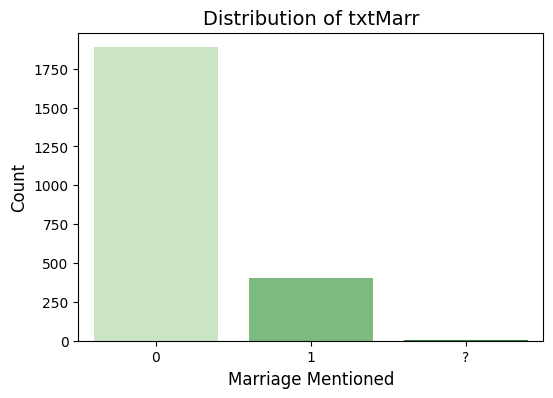

In [112]:
df = data[data['txtMarr'].isin(['0', '1'])]
plt.figure(figsize=(6, 4)) 
sns.countplot(x='txtMarr', data=data, palette='Greens') 
plt.title('Distribution of txtMarr', fontsize=14)
plt.xlabel('Marriage Mentioned', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [113]:
print(df.columns)

Index(['NOM', 'PRENOM', 'id', 'name', 'description', 'link', 'pstrN', 'pstrNF',
       'pstrNH', 'pstrVisages', 'pstrContact', 'txtMarr', 'txtCheat',
       'txtDivorce', 'txtRelAvant', 'txtRelPendant', 'love'],
      dtype='object')


## 4. Creating a bag of words

In developing a strategy to enhance the precision of text analysis, I opted to focus on word stems related to the theme of marriage rather than using a fixed set of words. This approach allows for a more nuanced and comprehensive capture of relevant terms, as it encompasses various derivations and conjugations of the core words.

In [114]:
def contains_marriage(description):
    """Detect presence of keywords related to marriage in a given description."""
    desc = description.lower()
    desc = desc.translate(str.maketrans('', '', string.punctuation)) 
    
    keywords = [
        'marri', 'marry', 'wedd', 'fianc', 'engag', 'bridal', 
        'matrimoni', 'wife', 'husband', 'spouse', 'groom', 'bride', 
        'nuptial', 'engagement', 'wedding', 'matrimony'
    ]
    results = {}
    for keyword in keywords:
        results[keyword] = 1 if re.search(rf'\b{keyword}\w*\b', desc) else 0

    return results

results_df = df['description'].apply(contains_marriage).apply(pd.Series)

df = pd.concat([df, results_df], axis=1)
pd.set_option('display.max_columns', None)
df['txtMarr'] = df['txtMarr'].astype(str)
df = df[df['txtMarr'].isin(['0', '1'])]

df['txtMarr'] = df['txtMarr'].astype(str)

## 3. Drop useless columns

In [115]:
colonnes_a_supprimer = [
    'link', 'pstrN', 'pstrNF', 'pstrNH', 'pstrVisages',
    'pstrContact', 'txtCheat', 'txtDivorce',
    'txtRelAvant', 'txtRelPendant', 'love',
    'NOM', 'PRENOM', 'id', 'name','description'
]

df = df.drop(columns=colonnes_a_supprimer)

In [116]:
df

,txtMarr,marri,marry,wedd,fianc,engag,bridal,matrimoni,wife,husband,spouse,groom,bride,nuptial,engagement,wedding,matrimony
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2316,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 5. txtMarr prediction

### 5.1. Data normalization

In [117]:
y = df['txtMarr']
features = df.drop(columns=['txtMarr'])
df = preprocess_data(df)

y = y.reset_index(drop=True)
features = features.reset_index(drop=True)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(features)
X = pd.DataFrame(X, columns = features.columns)

df = X.copy()
df['txtMarr'] = y


### 5.2. Train/test split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 666)

### 5.3. Logistic regression

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        24                  51
Accuracy: 0.9106753812636166


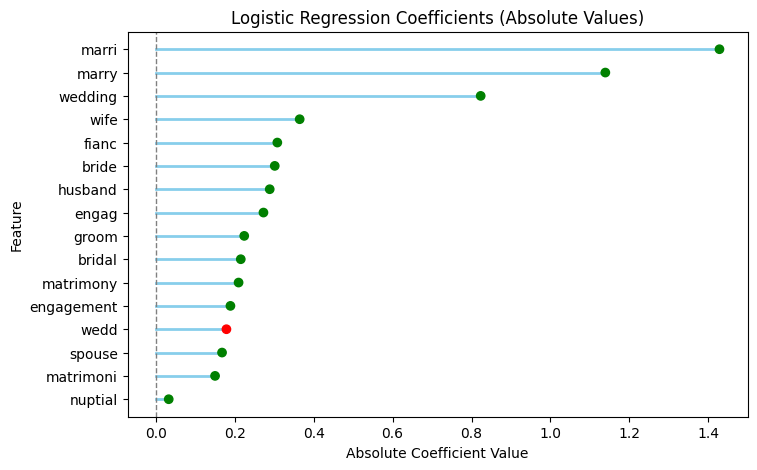

In [120]:
# Logistic Regression
reg = LogisticRegression(max_iter = 10000)
reg.fit(X_train, y_train)

coef = pd.Series(reg.coef_.flatten(), index = X_train.columns)
# Test the logistic regression
y_pred = reg.predict(X_test)

# Conflusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

# Accuracy
accuracy_logistic = accuracy_score(y_test, y_pred)
print("Accuracy:" , accuracy_logistic)

plot_sorted_coefficients(coef)

### 5.4. Lasso regression

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    369                  15
Marriage                        30                  45
Accuracy: 0.9019607843137255


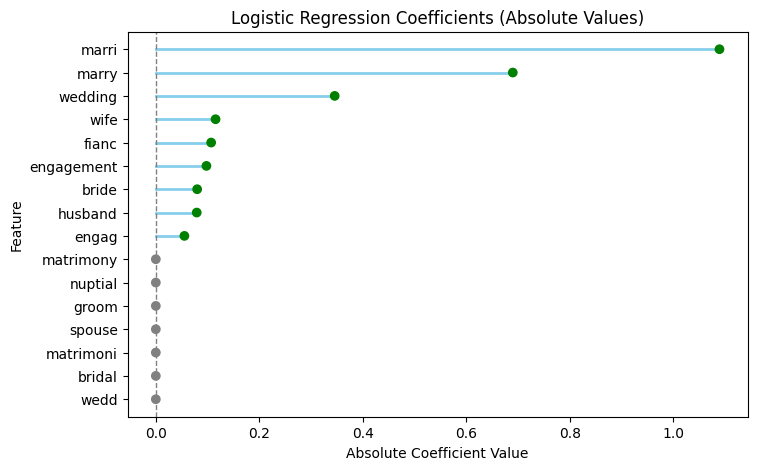

In [122]:
# Performing Lasso Regression
reg = LogisticRegression(C = 0.02, solver = 'saga', penalty = 'l1', max_iter = 10000)
reg.fit(X_train, y_train)

coef = pd.Series(reg.coef_.flatten(), index = X_train.columns)

# Test the logistic regression
y_pred_log = reg.predict(X_test)

# Conflusion matrix
cm = confusion_matrix(y_test, y_pred_log)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

accuracy_lasso = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy_lasso)

plot_sorted_coefficients(coef)

### 5.5. Neural Network

In [125]:
clf_150_neurons = MLPClassifier(
    hidden_layer_sizes=(200, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha = 0.001,
    tol=1e-6,
    batch_size=1000,
    random_state=666,
    verbose=0,
    learning_rate_init=0.001
)
# Train
clf_150_neurons.fit(X_train, y_train)

# Pred
y_train_pred = clf_150_neurons.predict(X_train)
y_test_pred = clf_150_neurons.predict(X_test)

Training Accuracy: 0.9355895196506551
Test Accuracy: 0.9128540305010894


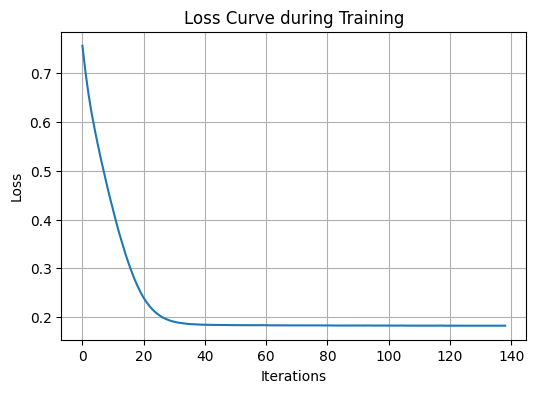

In [127]:
# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
accuracy_NN = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy_NN}")

# Loss curve
plt.figure(figsize=(6, 4))
plt.plot(clf_150_neurons.loss_curve_)
plt.title('Loss Curve during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [128]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                   1453                  50
Marriage                        68                 261
Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        23                  52


### 5.6 Second Neural Network

In [129]:
clf_150_neurons = MLPClassifier(
    hidden_layer_sizes=(50), 
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha=1, 
    tol=1e-6,
    batch_size=1000,
    random_state=666,
    verbose=0,
    learning_rate_init=0.01,
)

clf_150_neurons.fit(X_train, y_train)
y_train_pred = clf_150_neurons.predict(X_train)
y_test_pred = clf_150_neurons.predict(X_test)

Training Accuracy: 0.9355895196506551
Test Accuracy: 0.9128540305010894

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                   1453                  50
Marriage                        68                 261
Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        23                  52


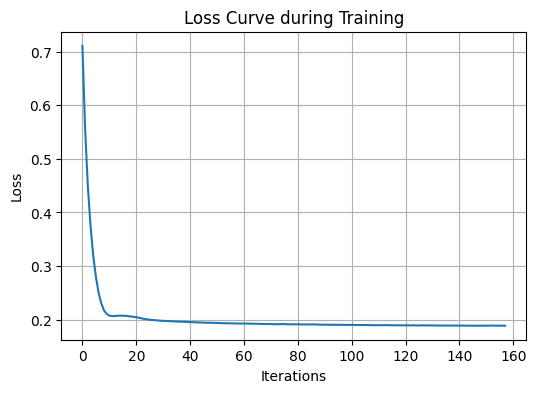

In [130]:
# Accuracy, loss curve and confusion matrix
train_accuracy = accuracy_score(y_train, y_train_pred)
accuracy_NN_upgraded = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy_NN_upgraded}")
print("")
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(6, 4))
plt.plot(clf_150_neurons.loss_curve_)
plt.title('Loss Curve during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [131]:
df1 = df


# **II. Word and sentence embedding**

## 3. txtMarr prediction

### 3.1 Logistic regression

In [132]:
# Performing Logistic Regression
reg = LogisticRegression(max_iter = 10000)
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_.flatten(), index = X_train.columns)
y_pred = reg.predict(X_test)

Accuracy: 0.9106753812636166

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        24                  51


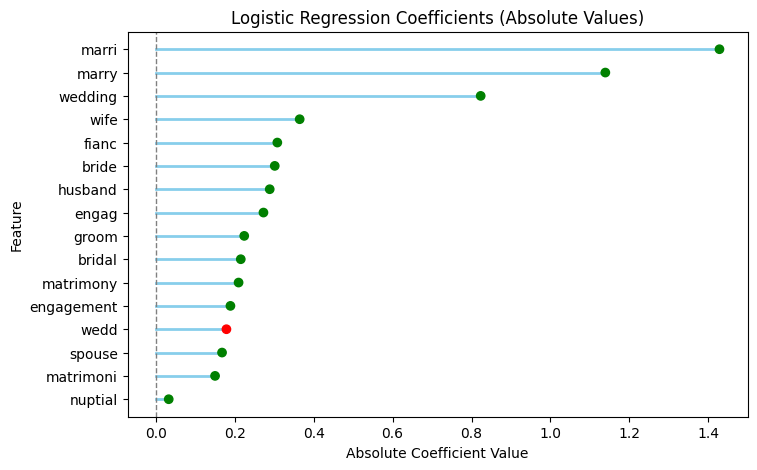

In [133]:
# Conflusion matrix

accuracy_logistic2 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_logistic2)
print("")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

plot_sorted_coefficients(coef)


### 3.2 Lasso regression

Accuracy: 0.9128540305010894

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    368                  16
Marriage                        24                  51


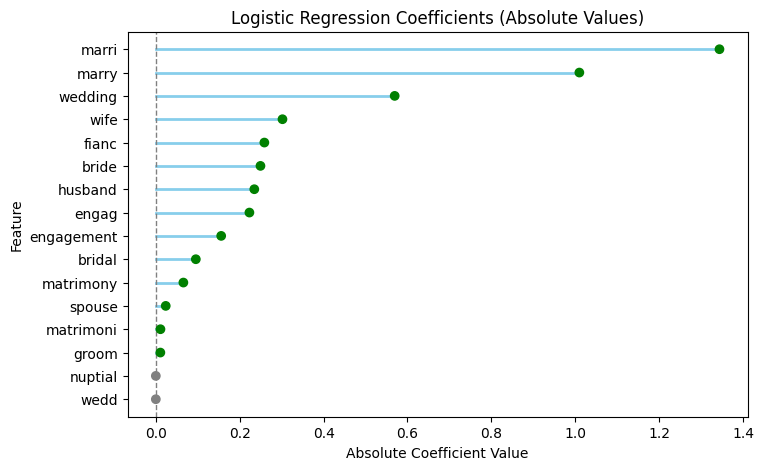

In [134]:
reg = LogisticRegression(C = 0.1, solver = 'saga', penalty = 'l1', max_iter = 10000) # L1 regularization
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_.flatten(), index = X_train.columns)
y_pred_log = reg.predict(X_test)

accuracy_lasso2 = accuracy_score(y_test, y_pred_log)
print("Accuracy:",accuracy_lasso2)
print()
cm = confusion_matrix(y_test, y_pred_log)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

plot_sorted_coefficients(coef)

### 3.3 Neural Network

In [135]:
# Neural network
clf_150_neurons = MLPClassifier(
    hidden_layer_sizes=(200, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha = 0.001,
    tol=1e-6,
    batch_size=1000,
    random_state=666,
    verbose=0,
    learning_rate_init=0.001
)

clf_150_neurons.fit(X_train, y_train)
y_train_pred = clf_150_neurons.predict(X_train)
y_test_pred = clf_150_neurons.predict(X_test)

Training Accuracy: 0.9355895196506551
Test Accuracy: 0.9128540305010894

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                   1453                  50
Marriage                        68                 261
Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        23                  52


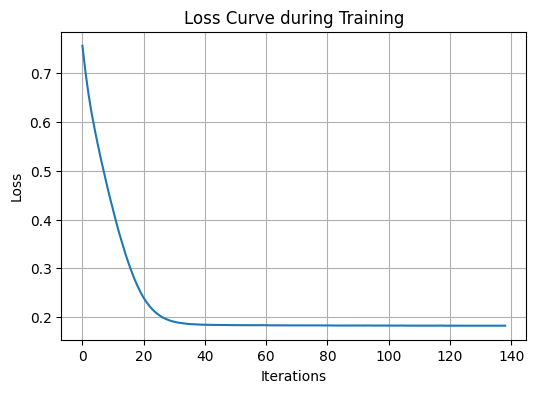

In [136]:
# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
accuracy_NN2 = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy_NN2}")
print('')
# Matrix
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

# Curve
plt.figure(figsize=(6, 4))
plt.plot(clf_150_neurons.loss_curve_)
plt.title('Loss Curve during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### 3.4 Second Neural Network

In [137]:
clf_150_neurons = MLPClassifier(
    hidden_layer_sizes=(50), 
    activation='relu',
    solver='adam',
    max_iter=1000,
    alpha=1,
    tol=1e-6,
    batch_size=1000,
    random_state=666,
    verbose=0,
    learning_rate_init=0.01, 
)
clf_150_neurons.fit(X_train, y_train)
y_train_pred = clf_150_neurons.predict(X_train)
y_test_pred = clf_150_neurons.predict(X_test)

Training Accuracy: 0.9355895196506551
Test Accuracy: 0.9128540305010894

Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                   1453                  50
Marriage                        68                 261
Confusion Matrix:
             Predicted no marriage  Predicted marriage
No marriage                    367                  17
Marriage                        23                  52


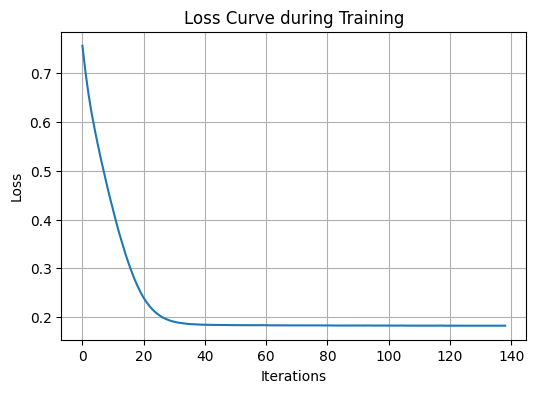

In [ ]:
# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
accuracy_NN_upgraded2 = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy_NN_upgraded2}")
print("")

# Matrix
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=['No marriage', 'Marriage'], columns=['Predicted no marriage', 'Predicted marriage'])
print("Confusion Matrix:")
print(cm_df)

# Curve
plt.figure(figsize=(6, 4))
plt.plot(clf_150_neurons.loss_curve_)
plt.title('Loss Curve during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [138]:
df2 = df


# **IV. Conclusion**

In [139]:
data = {
    ('BW', 'Model'): ['Logistic Regression', 'Lasso Regression', 'NN', 'NN upgraded'],
    ('BW', 'Accuracy'): [accuracy_logistic, accuracy_lasso, accuracy_NN, accuracy_NN_upgraded],
    ('WE+SE', 'Model'): ['Logistic Regression2', 'Lasso Regression2', 'NN2', 'NN upgraded2'],
    ('WE+SE', 'Accuracy'): [accuracy_logistic2, accuracy_lasso2, accuracy_NN2, accuracy_NN_upgraded2],
}

accuracy_table = pd.DataFrame(data)
display(accuracy_table)
max_accuracy = accuracy_table[[( 'BW', 'Accuracy'), ('WE+SE', 'Accuracy')]].max().max()
print(f"The maximum accuracy across all models is: {max_accuracy}")

BW                           WE+SE          
                 Model  Accuracy                 Model  Accuracy
0  Logistic Regression  0.910675  Logistic Regression2  0.910675
1     Lasso Regression  0.901961     Lasso Regression2  0.912854
2                   NN  0.912854                   NN2  0.912854
3          NN upgraded  0.912854          NN upgraded2  0.912854

The maximum accuracy across all models is: 0.9128540305010894


The highest accuracy achieved across all models is 0.9128, highlighting the effectiveness of the Neural Network used.